In [ ]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, LeakyReLU, Dense
from sklearn.model_selection import train_test_split

In [ ]:
params = {
    'latitude': 22.572645,
    'longitude' :88.363892,
    'start_date' : '2023-06-01',
    'end_date': '2023-07-30',
    'hourly': {'temperature_2m','relativehumidity_2m','windspeed_10m'}
}
result = requests.get("https://api.open-meteo.com/v1/forecast",params = params).json()
print(result)

{'latitude': 22.625, 'longitude': 88.375, 'generationtime_ms': 67.38197803497314, 'utc_offset_seconds': 0, 'timezone': 'GMT', 'timezone_abbreviation': 'GMT', 'elevation': 12.0, 'hourly_units': {'time': 'iso8601', 'temperature_2m': '°C', 'relativehumidity_2m': '%', 'windspeed_10m': 'km/h'}, 'hourly': {'time': ['2023-06-01T00:00', '2023-06-01T01:00', '2023-06-01T02:00', '2023-06-01T03:00', '2023-06-01T04:00', '2023-06-01T05:00', '2023-06-01T06:00', '2023-06-01T07:00', '2023-06-01T08:00', '2023-06-01T09:00', '2023-06-01T10:00', '2023-06-01T11:00', '2023-06-01T12:00', '2023-06-01T13:00', '2023-06-01T14:00', '2023-06-01T15:00', '2023-06-01T16:00', '2023-06-01T17:00', '2023-06-01T18:00', '2023-06-01T19:00', '2023-06-01T20:00', '2023-06-01T21:00', '2023-06-01T22:00', '2023-06-01T23:00', '2023-06-02T00:00', '2023-06-02T01:00', '2023-06-02T02:00', '2023-06-02T03:00', '2023-06-02T04:00', '2023-06-02T05:00', '2023-06-02T06:00', '2023-06-02T07:00', '2023-06-02T08:00', '2023-06-02T09:00', '2023-06-

In [ ]:
df = pd.DataFrame(result['hourly'])
df.head()

,time,temperature_2m,relativehumidity_2m,windspeed_10m
0,2023-06-01T00:00,29.2,90,3.7
1,2023-06-01T01:00,30.1,86,5.4
2,2023-06-01T02:00,31.5,80,6.2
3,2023-06-01T03:00,33.0,74,7.9
4,2023-06-01T04:00,34.7,66,7.1


In [ ]:
df.set_index("time", inplace = True)

In [ ]:
scaler = MinMaxScaler()
data = scaler.fit_transform(df)

In [ ]:
x_train,x_test, y_train,y_test = train_test_split(data,data[:,0],train_size = 0.8,shuffle = False)

In [ ]:
x_train.shape[0]

1152

In [ ]:
x_test.shape[0]

288

In [ ]:
win_length = 10
batch_size = 5
num_features = 3
train_generator = TimeseriesGenerator(x_train,y_train, win_length, batch_size = batch_size)
test_generator = TimeseriesGenerator(x_test,y_test, win_length, batch_size = batch_size)

In [ ]:
model = Sequential()
model.add(LSTM(24, input_shape = (win_length, num_features), return_sequences = True))
model.add(LeakyReLU(alpha = 0.2))
model.add(Dropout(0.5))
model.add(LSTM(24, return_sequences = True))
model.add(LeakyReLU(alpha = 0.2))
model.add(LSTM(24, return_sequences = False))
model.add(LeakyReLU(alpha = 0.2))
model.add(Dense(1))
model.compile(loss = "mean_squared_error", metrics = "mean_squared_error")

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 24)            2688      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 10, 24)            0         
                                                                 
 dropout (Dropout)           (None, 10, 24)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 24)            4704      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 10, 24)            0         
                                                                 
 lstm_2 (LSTM)               (None, 24)                4704      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 24)                0

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 15)

In [ ]:
history = model.fit(train_generator,epochs = 100,validation_data = test_generator,shuffle = False, callbacks = [callback])

Epoch 1/100
229/229 [==============================] - 7s 26ms/step - loss: 0.0398 - mean_squared_error: 0.0398 - val_loss: 0.0156 - val_mean_squared_error: 0.0156
Epoch 2/100
229/229 [==============================] - 5s 20ms/step - loss: 0.0258 - mean_squared_error: 0.0258 - val_loss: 0.0094 - val_mean_squared_error: 0.0094
Epoch 3/100
229/229 [==============================] - 4s 18ms/step - loss: 0.0153 - mean_squared_error: 0.0153 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 4/100
229/229 [==============================] - 5s 20ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 5/100
229/229 [==============================] - 5s 22ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 6/100
229/229 [==============================] - 4s 18ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 7/100
229/

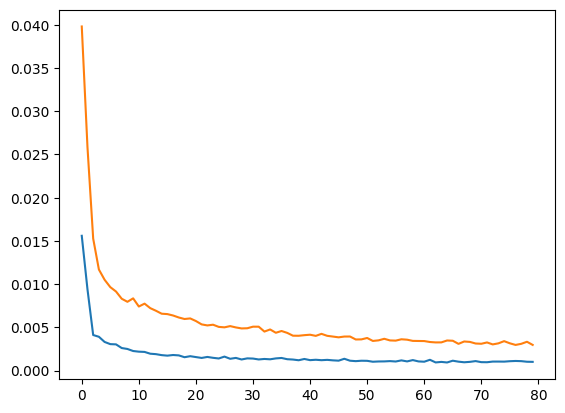

In [ ]:
plt.plot(history.history["val_loss"],label=  "val_loss")
plt.plot(history.history["loss"],label = "loss")

In [ ]:
model.save("model_temp.keras")

In [ ]:
prediction  = model.predict_generator(test_generator)

<ipython-input-27-7963bfab3b74>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  prediction  = model.predict_generator(test_generator)


In [ ]:
test_data = pd.DataFrame(scaler.inverse_transform(pd.concat([pd.DataFrame(x_test[:,:2]),pd.DataFrame(y_test)],axis = 1)))
test_data

,0,1,2
0,27.9,91.0,2.486364
1,28.3,90.0,2.977273
2,29.1,85.0,3.959091
3,29.8,80.0,4.818182
4,30.6,77.0,5.800000
...,...,...,...
283,28.5,92.0,3.222727
284,28.2,94.0,2.854545
285,27.9,94.0,2.486364
286,27.7,94.0,2.240909


In [ ]:
time = df.index
pred_time = time[1152:]

In [ ]:
pred_df = pd.concat([pd.DataFrame(prediction[:,0]),pd.DataFrame(x_test[:,1:][win_length:])], axis = 1)
pred_df =  pd.DataFrame(scaler.inverse_transform(pred_df))
pred_df.iloc[:][0]

0      31.880159
1      31.308128
2      30.447313
3      29.883624
4      29.218781
         ...    
273    28.433217
274    28.175862
275    27.892365
276    27.571798
277    27.285104
Name: 0, Length: 278, dtype: float64

In [ ]:
df_pred = pd.DataFrame(pred_df.iloc[:][0])
df_test = pd.DataFrame(test_data[win_length:][0])
df_pred.index = pred_time[win_length:]
df_test.index = pred_time[win_length:]

In [ ]:
df_compare = pd.concat([df_pred,df_test], axis = 1)
df_compare.columns = ["prediction","actual"]

<Axes: xlabel='time'>

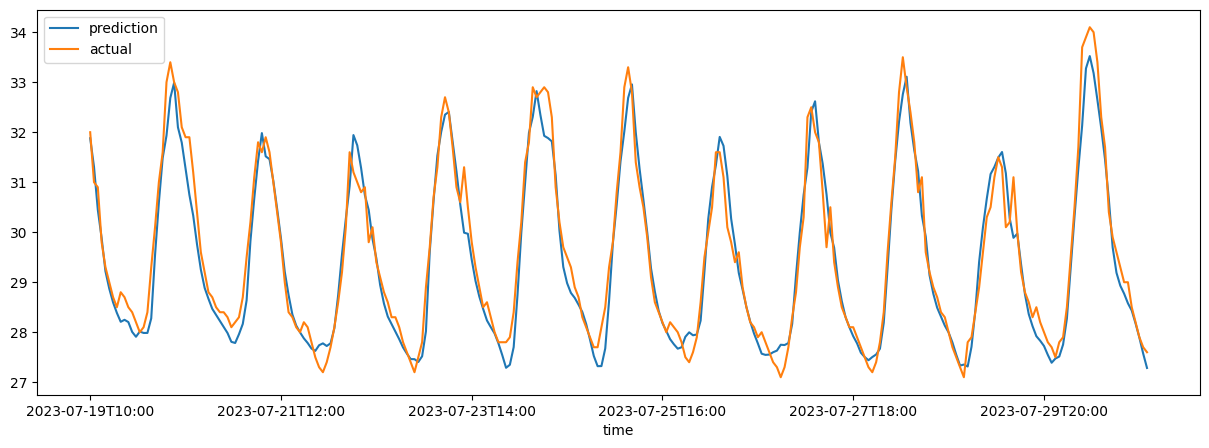

In [ ]:
df_compare.plot(figsize = (15,5))